## Post-process a finetuned LLM

Test and upload a finetuned language model

## Setup

In [1]:
import transformers
import torch
import tensorflow as tf

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
!nvidia-smi

Sun Jul  2 16:26:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA H100 PCIe    On   | 00000000:06:00.0 Off |                    0 |
| N/A   29C    P0    49W / 350W |      3MiB / 81559MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
free_in_GB = int(torch.cuda.mem_get_info()[0] / 1024**3)
max_memory = f"{free_in_GB-2}GB"
n_gpus = torch.cuda.device_count()
max_memory = {i: max_memory for i in range(n_gpus)}
print("max memory: ", max_memory)

max memory:  {0: '76GB'}


## Loss curve

In [4]:
# assumes you have already run `sft-instruction-llm.py`
# see documentation and comments therein for details
# recommendation: run `sft-instruction-llm.py` directly from the terminal
# by default, the mpt-7b instruction model demo is used


# load the train loss from the finetuning events log
train_steps = []
train_loss = []
path_to_events_file = "./results/runs/Jul02_13-36-31_209-20-156-99/events.out.tfevents.1688304998.209-20-156-99.72800.0"
for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
    for v in e.summary.value:
        if "loss" in v.tag:
            train_loss.append(v.simple_value)
            train_steps.append(e.step)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


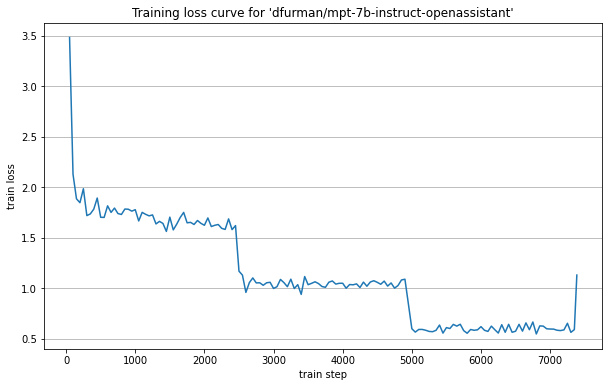

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss)
plt.title("Training loss curve for 'dfurman/mpt-7b-instruct-openassistant'")
plt.ylabel("train loss")
plt.xlabel("train step")
plt.grid(which="major", axis="y")
plt.show()

With a supervised finetuned (sft) model in hand, we can test it on some basic prompts and then upload it to the Hugging Face hub either as a public or private model repo, depending on the use case.

In [8]:
# load assets

model_id = "./results/checkpoint-7386"

# mpt tokenizer load
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

# mpt llm load
config = transformers.AutoConfig.from_pretrained(model_id, trust_remote_code=True)

# custom options
config.attn_config[
    "attn_impl"
] = "triton"  # Optional triton attention for improved latency
config.init_device = "cuda"  # For fast initialization directly on GPU!
# config.max_seq_len = 4096 # (input + output) tokens can now be up to 4096
config.torch_dtype = "bfloat16"  # Set float16 data type

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    config=config,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto",
)

config

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Instantiating an MPTForCausalLM model from /home/ubuntu/.cache/huggingface/modules/transformers_modules/mosaicml/mpt-7b/a78c1fa391580242211a2f516cf9ef10c86713c8/modeling_mpt.py
You are using config.init_device='cuda', but you can also use config.init_device="meta" with Composer + FSDP for fast initialization.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

MPTConfig {
  "_name_or_path": "./results/checkpoint-7386",
  "architectures": [
    "MPTForCausalLM"
  ],
  "attn_config": {
    "alibi": true,
    "alibi_bias_max": 8,
    "attn_impl": "triton",
    "attn_pdrop": 0,
    "attn_type": "multihead_attention",
    "attn_uses_sequence_id": false,
    "clip_qkv": null,
    "prefix_lm": false,
    "qk_ln": false,
    "softmax_scale": null
  },
  "auto_map": {
    "AutoConfig": "mosaicml/mpt-7b--configuration_mpt.MPTConfig",
    "AutoModelForCausalLM": "mosaicml/mpt-7b--modeling_mpt.MPTForCausalLM"
  },
  "d_model": 4096,
  "emb_pdrop": 0,
  "embedding_fraction": 1.0,
  "expansion_ratio": 4,
  "init_config": {
    "emb_init_std": null,
    "emb_init_uniform_lim": null,
    "fan_mode": "fan_in",
    "init_div_is_residual": true,
    "init_gain": 0,
    "init_nonlinearity": "relu",
    "init_std": 0.02,
    "name": "kaiming_normal_",
    "verbose": 0
  },
  "init_device": "cuda",
  "learned_pos_emb": true,
  "logit_scale": null,
  "max_seq_len"

## Basic instruction tests

In [9]:
# text generation function


def mpt_generate(
    model: transformers.AutoModelForCausalLM,
    tokenizer: transformers.AutoTokenizer,
    prompt: str,
    max_new_tokens: int = 128,
    temperature: int = 1.0,
) -> str:
    """
    Initialize the pipeline
    Uses Hugging Face GenerationConfig defaults
        https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/text_generation#transformers.GenerationConfig
    Args:
        model (transformers.AutoModelForCausalLM): Falcon model for text generation
        tokenizer (transformers.AutoTokenizer): Tokenizer for model
        prompt (str): Prompt for text generation
        max_new_tokens (int, optional): Max new tokens after the prompt to generate. Defaults to 128.
        temperature (float, optional): The value used to modulate the next token probabilities.
            Defaults to 1.0
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        return_token_type_ids=False,
    ).to(
        device
    )  # tokenize inputs, load on device

    # when running Torch modules in lower precision, it is best practice to use the torch.autocast context manager.
    with torch.autocast("cuda", dtype=torch.bfloat16):
        response = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            return_dict_in_generate=True,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
        )

    decoded_output = tokenizer.decode(
        response["sequences"][0],
        skip_special_tokens=True,
    )  # grab output in natural language

    return decoded_output[len(prompt) :]  # remove prompt from output

In [24]:
prompt = "Write me a numbered list of things to do in New York City.\n"

response = mpt_generate(
    model,
    tokenizer,
    prompt,
    max_new_tokens=100,
    temperature=0.92,
)

print(response)

Sure! Here's a numbered list of 100 things to do in New York City:

1. Visit the Statute of Liberty
2. Explore the Empire State Building
3. Walk through Central Park
4. Take a tour of the Metropolitan Museum of Art
5. Visit the Museum of Modern Art
6. Explore the Brooklyn Museum
7. Watch a show at the Lincoln Center
8. Visit the Statute of Liberty
9. Explore the Empire State Building


In [25]:
prompt = "Daniel is in need of a haircut. His barber works Mondays, Wednesdays, and Fridays. So, Daniel went in for a haircut on Sunday. Does this make logical sense?\n"

response = mpt_generate(
    model,
    tokenizer,
    prompt,
    max_new_tokens=100,
    temperature=0.92,
)

print(response)

No, it does not make logical sense for Daniel to go in for a haircut on Sunday, as the barber is only available on Mondays, Wednesdays, and Fridays. Therefore, it is not possible for Daniel to get a haircut on Sunday, as the barber is not available. It would make more sense for Daniel to go in for a haircut on a day that the barber is available, such as Monday, Wednesday, or Friday.



In [26]:
prompt = "Write a short email inviting my friends to a dinner party on Friday. Respond succinctly.\n"

response = mpt_generate(
    model,
    tokenizer,
    prompt,
    max_new_tokens=200,
    temperature=0.92,
)

print(response)

Subject: Invitation to Dinner Party

Dear friends,

I hope this email finds you all well. I'm writing to invite you to a dinner party that I'm hosting on Friday night. The party will be a small gathering of friends and family, and I'd love to have you all join us.

The dinner will be a casual affair, with plenty of delicious food and drinks to enjoy. I'm planning to cook up some of my favorite dishes, so please let me know if you're interested in helping me prepare or if you'd like to bring a dish to the party.

The party will start at 6:30 PM, so please let me know if you're able to make it by that time. And don't forget to bring your appetite!

Thank you for your time and consideration. I look forward to seeing you all on Friday night.

Best regards,
[Your Name]

If you have any questions or would


## Upload model to Hugging Face
1. Before running the cells below, create a model on your Hugging Face account. It can be a private or public repo and work with the below code.

In [16]:
!pip install huggingface_hub

Defaulting to user installation because normal site-packages is not writeable


In [17]:
from huggingface_hub import notebook_login

notebook_login()

In [18]:
!git config --global credential.helper store

In [19]:
# push to hub
model_id_load = "dfurman/mpt-7b-instruct-openassistant"

# tokenizer
tokenizer.push_to_hub(model_id_load, use_auth_token=True)

CommitInfo(commit_url='https://huggingface.co/dfurman/mpt-7b-instruct-openassistant/commit/2f3b051a7621991d214d0eb93c71135e958c5ae4', commit_message='Upload tokenizer', commit_description='', oid='2f3b051a7621991d214d0eb93c71135e958c5ae4', pr_url=None, pr_revision=None, pr_num=None)

In [20]:
# safetensors
model.push_to_hub(model_id_load, use_auth_token=True, safe_serialization=True)
# torch tensors
model.push_to_hub(model_id_load, use_auth_token=True)

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.36G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.36G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dfurman/mpt-7b-instruct-openassistant/commit/a8223ee2b7712d06865c62d553c3aaa55e08ad56', commit_message='Upload MPTForCausalLM', commit_description='', oid='a8223ee2b7712d06865c62d553c3aaa55e08ad56', pr_url=None, pr_revision=None, pr_num=None)